In [1]:
!pip install pytorch_msssim

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pytorch_msssim.ssim as cal_ssim

In [14]:
print(torch. __version__) 
print(np. __version__) 
print(matplotlib. __version__) 

1.9.0+cu111
1.19.5
3.2.2


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.empty_cache()
!nvidia-smi

Mon Nov  1 00:03:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, 
                      padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1,
                      bias=False)
        )

    def forward(self, x):
        return x + self.block(x)

class VQVAE(nn.Module):
    def __init__(self, img_channels, latent_size, latent_dim):
        super(VQVAE, self).__init__()
        
        self.K = latent_size
        self.D = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, self.D, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.D, self.D, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
        )
        
        self.codebook = nn.Embedding(self.K, self.D)
        self.codebook.weight.data.uniform_(-1/self.K, 1/self.K)
        
        self.decoder = nn.Sequential(
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
            nn.ConvTranspose2d(self.D, self.D, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.D, img_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        
    def vector_quantize(self, z_e):
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_shape = z_e.shape

        flat_z_e = z_e.view(-1, self.D)
        
        distances = (torch.sum(flat_z_e**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(flat_z_e, self.codebook.weight.t()))
        
        q = torch.argmin(distances, dim=1, keepdim=True).view(z_e_shape[:-1])

        z_q = self.codebook(q)

        codebook_loss = F.mse_loss(z_q.detach(), z_e)
        commit_loss = F.mse_loss(z_q, z_e.detach())
        vq_loss = codebook_loss + commit_loss

        z_q = z_e + (z_q - z_e).detach()
        
        return q, vq_loss, z_q.permute(0, 3, 1, 2).contiguous()
    
    def forward(self, imgs):
        z_e = self.encoder(imgs)
        _, vq_loss, encoded = self.vector_quantize(z_e)
        decoded = self.decoder(encoded)
        
        return encoded, decoded, vq_loss

In [6]:
class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return torch.tanh(x) * torch.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual


        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h):
        if self.mask_type == 'A':
            self.make_causal()

        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert)

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz)
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # self.norm = nn.BatchNorm2d(dim)
        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        # self.apply(weights_init)

    def forward(self, x):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, W)

        # x = self.norm(x)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h)

        return self.output_conv(x_h)

    def generate(self, shape=(64, 64), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [7]:
def test(model, test_loader):
    ssim = 0
    for batch, imgs in enumerate(test_loader):
        imgs = imgs.to(device)
        _, decoded, _ = model(imgs)
        imgs = make_grid(imgs.detach().data).unsqueeze(0)
        decoded = make_grid(decoded.detach().data).unsqueeze(0)
        ssim += cal_ssim(imgs, decoded, data_range=1, size_average=False).item()
    print("Average SSIM on test dataset:", ssim/(batch+1))

In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

test_data = torch.load('/content/gdrive/MyDrive/data/mri_brain_test.pt') 
vqvae_checkpoint = torch.load('/content/gdrive/MyDrive/model/vqvae_trained.pt')
pixelcnn_checkpoint = torch.load('/content/gdrive/MyDrive/model/pixelcnn_trained.pt')

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
                                          shuffle=True, num_workers=0)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
vqvae = VQVAE(1, vqvae_checkpoint['K'], vqvae_checkpoint['D']).to(device)
vqvae.load_state_dict(vqvae_checkpoint['state_dict'])

pixelcnn = GatedPixelCNN(pixelcnn_checkpoint['K'], 64, pixelcnn_checkpoint['nlayers']).to(device)
pixelcnn.load_state_dict(pixelcnn_checkpoint['state_dict'])

<All keys matched successfully>

In [10]:
test(vqvae, test_loader)

Average SSIM on test dataset: 0.906753911253284


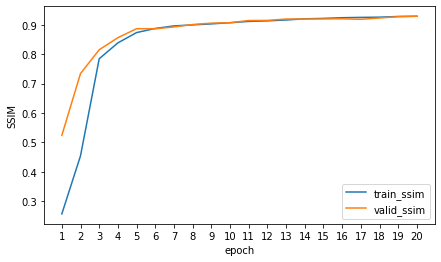

In [47]:
train_status = vqvae_checkpoint['train_status']

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(train_status['train_ssim'])+1), train_status['train_ssim'], label='train_ssim')
plt.plot(range(1, len(train_status['valid_ssim'])+1), train_status['valid_ssim'], label='valid_ssim')
plt.legend(loc='best')
plt.xticks(range(1, len(train_status['train_ssim'])+1))
plt.xlabel('epoch')
plt.ylabel('SSIM')
plt.savefig('/content/gdrive/MyDrive/images/vqvae_train_status.png', bbox_inches='tight', dpi=300)

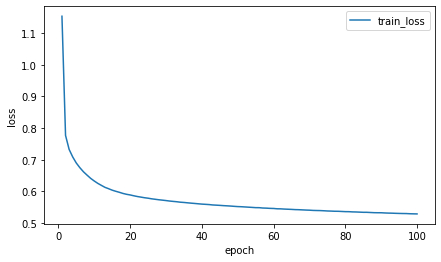

In [48]:
train_status = pixelcnn_checkpoint['train_status']

plt.figure(figsize=(7, 4))
plt.plot(range(1, len(train_status['train_loss'])+1), train_status['train_loss'], label='train_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('/content/gdrive/MyDrive/images/prior_train_status.png', bbox_inches='tight', dpi=300)

In [33]:
pixelcnn.eval()
generated_q = pixelcnn.generate(shape=(64, 64), batch_size=32)


In [19]:
def show_grid(img, save_path=None):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

def show_generated(vqvae, generated_q, save_path=None):
    generated_encoded = vqvae.codebook(generated_q).permute(0, 3, 1, 2).contiguous()
    generated = vqvae.decoder(generated_encoded)
    show_grid(make_grid(generated.detach().cpu().data, nrow=8, padding=0), save_path=save_path)

def show_q(q, save_path=None):
    plt.imshow(q.detach().cpu().numpy()[0], cmap='gray')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

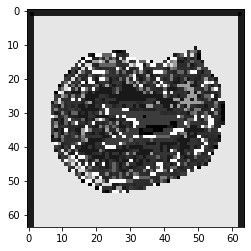

In [36]:
# plt.imshow(generated_q.cpu().detach().numpy()[0], cmap='gray')
# show_q(generated_q, save_path='/content/gdrive/MyDrive/images/generated_q.png')

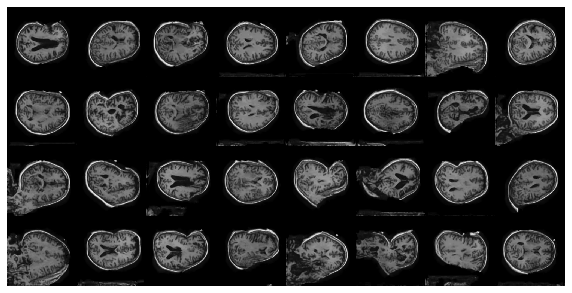

In [37]:
# show_generated(vqvae, generated_q, save_path='/content/gdrive/MyDrive/images/generated_imgs.png')

In [27]:
# vqvae.eval()

# img = next(iter(test_loader))
# img = img.to(device)

# z_e = vqvae.encoder(img)
# q, _, _ = vqvae.vector_quantize(z_e)

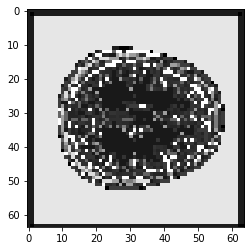

In [28]:
# show_q(q, save_path='/content/gdrive/MyDrive/images/test_q.png')

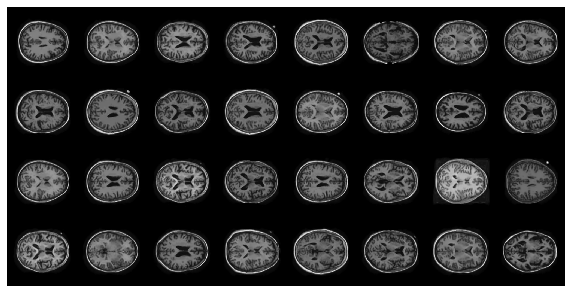

In [29]:
# show_generated(vqvae, q, save_path='/content/gdrive/MyDrive/images/test_imgs.png')

In [52]:
img = next(iter(test_loader))
img = img.to(device)
encoded, decoded, _ = vqvae(img)

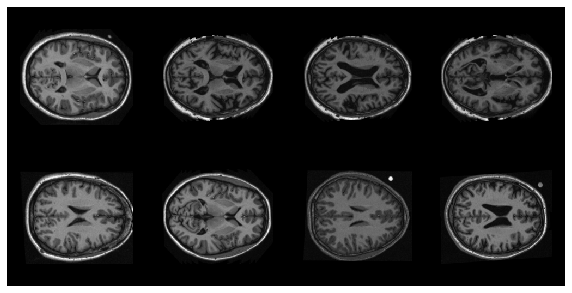

In [55]:
show_grid(make_grid(img.cpu().data[0:8], nrow=4, padding=0), save_path='/content/gdrive/MyDrive/images/original.png')

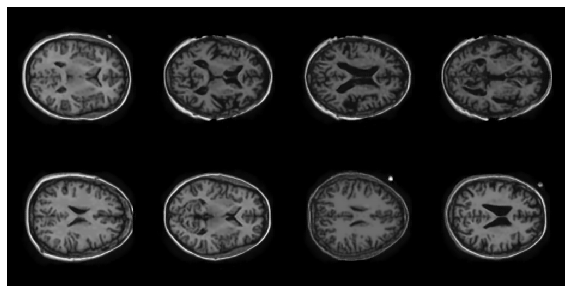

In [56]:
show_grid(make_grid(decoded.cpu().data[0:8], nrow=4, padding=0), save_path='/content/gdrive/MyDrive/images/reconst.png')